# Расчёт стоимости европейского колл-опциона в модели Блэка-Шоулза.



<ipython-input-27-bb96640cdcd5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_data, ignore_index=True)


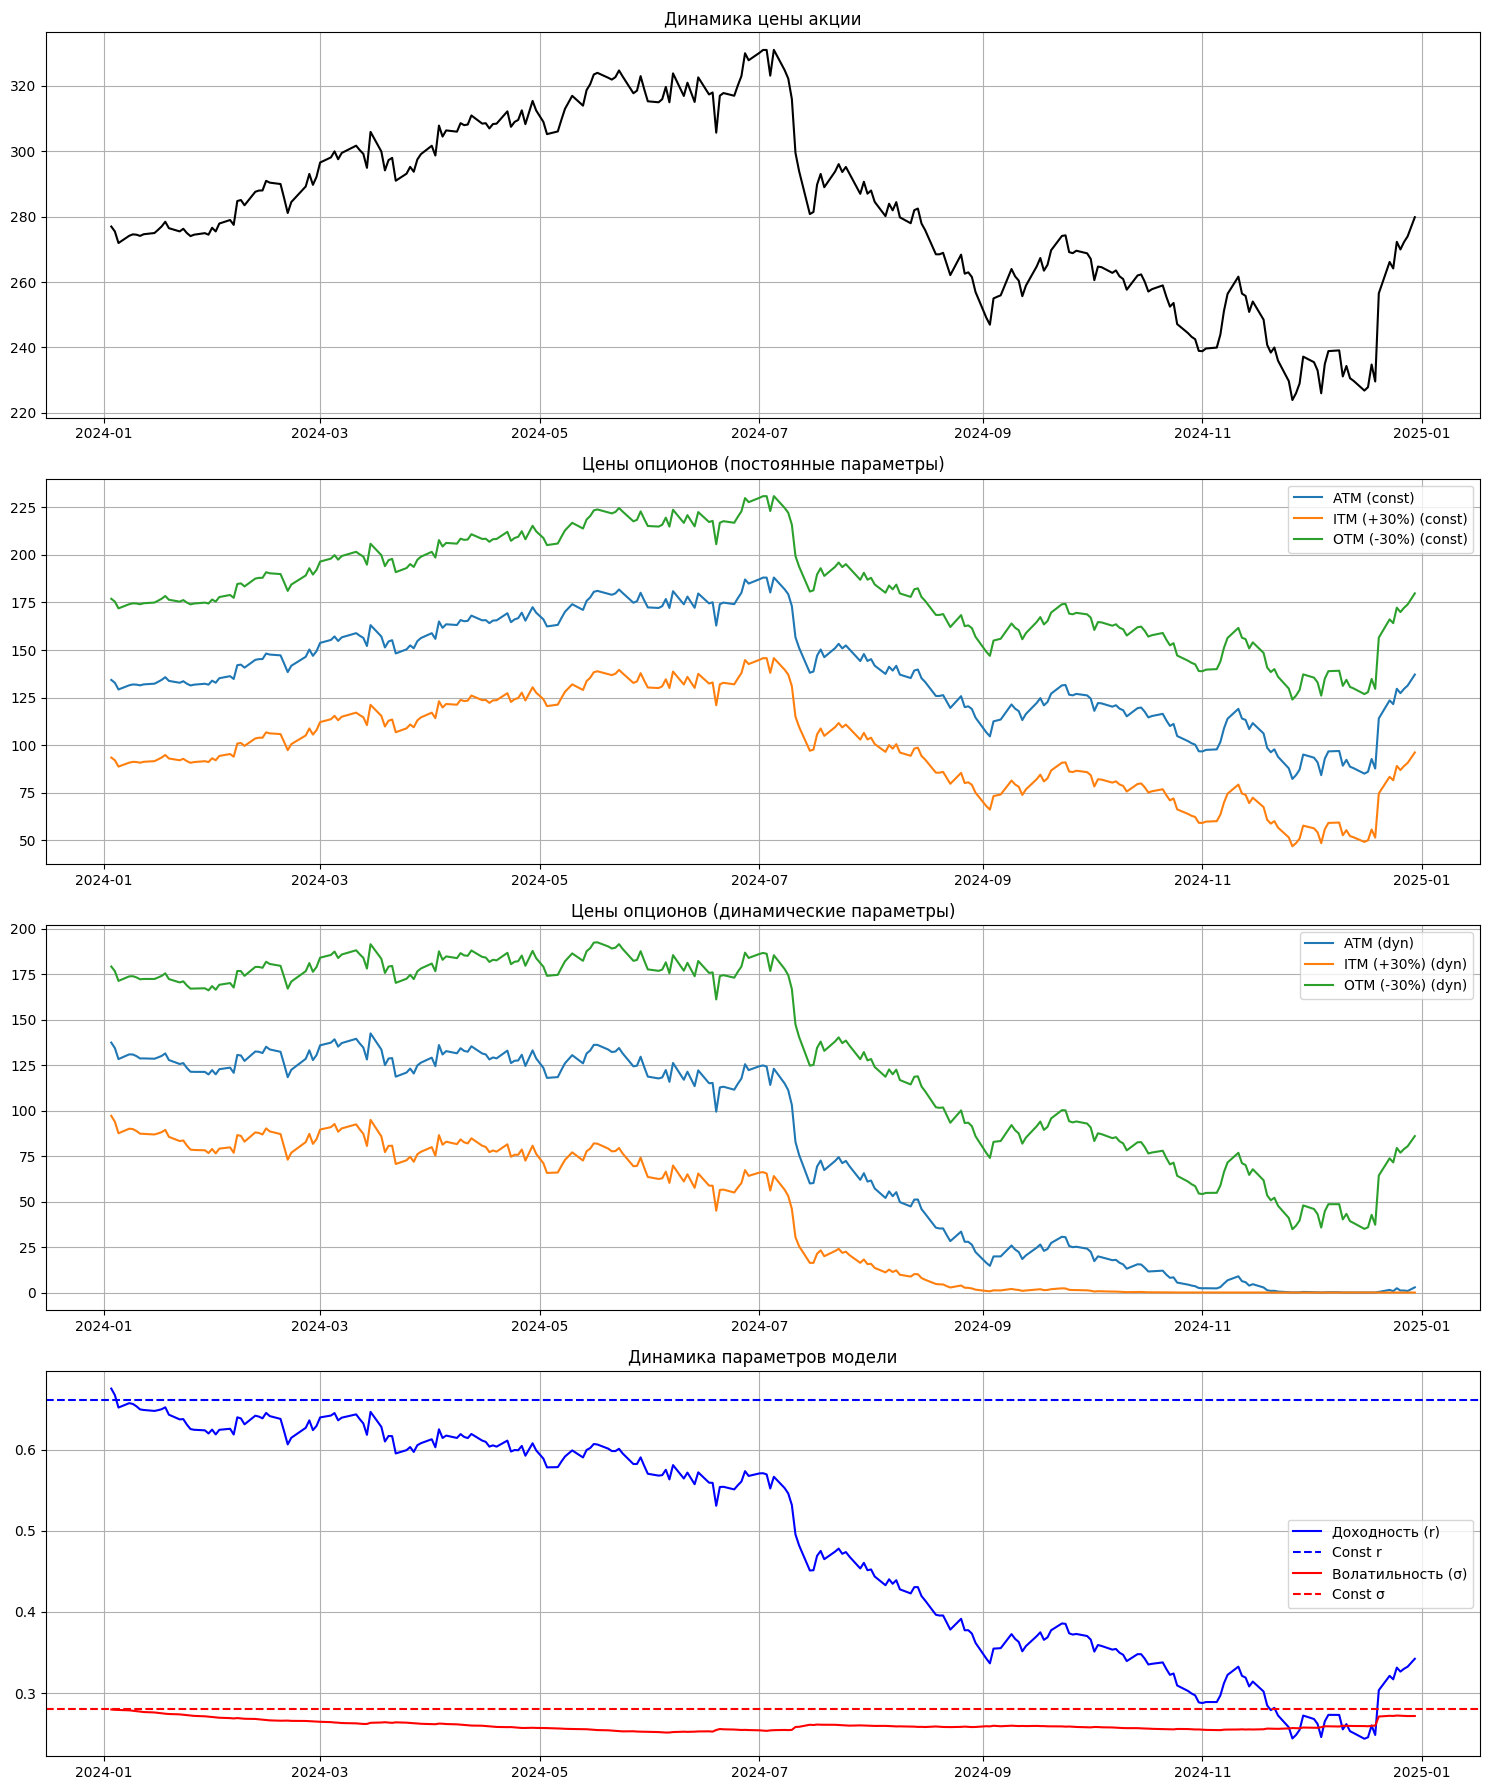

Результаты сохранены. Константные параметры: r = 0.6618, σ = 0.2799


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import requests

# 1. Исправленная функция загрузки данных
def get_moex_data(ticker='SBER', start='2023-01-01', end='2024-12-31'):
    url = f'https://iss.moex.com/iss/history/engines/stock/markets/shares/securities/{ticker}.json'
    all_data = []
    start_index = 0
    batch_size = 100

    while True:
        params = {'from': start, 'till': end, 'start': start_index, 'iss.meta': 'off'}
        try:
            response = requests.get(url, params=params)
            data = response.json()

            if not data['history']['data']:
                break

            batch_df = pd.DataFrame(data['history']['data'])
            if batch_df.empty:
                break

            batch_df.columns = [col.lower() for col in data['history']['columns']]
            all_data.append(batch_df)
            start_index += batch_size

            if len(batch_df) < batch_size:
                break
        except Exception as e:
            print(f"Ошибка при получении данных: {e}")
            break

    if not all_data:
        raise ValueError("Не удалось получить данные")

    df = pd.concat(all_data, ignore_index=True)
    df['tradedate'] = pd.to_datetime(df['tradedate'])
    df.set_index('tradedate', inplace=True)
    df = df[~df.index.duplicated(keep='first')].sort_index()
    return df[['close']]

# 2. Функции для расчета параметров
def calculate_daily_returns(prices):
    return np.log(prices['close'] / prices['close'].shift(1)).dropna()

def estimate_parameters(daily_returns):
    r = float(daily_returns.mean() * 252)  # Явное преобразование к float
    sigma = float(daily_returns.std() * np.sqrt(252))
    return r, sigma

# 3. Формула Блэка-Шоулза (без изменений)
def black_scholes(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# 4. Исправленная основная функция расчета
def calculate_black_scholes_options(ticker='SBER'):
    # Загрузка данных за 2 года
    prices = get_moex_data(ticker, '2023-01-01', '2024-12-31')

    # Разделение на первый и второй год
    year1_prices = prices[prices.index < '2024-01-01']
    year2_prices = prices[prices.index >= '2024-01-01']

    # Расчет параметров по первому году
    daily_returns = calculate_daily_returns(year1_prices)
    r_const, sigma_const = estimate_parameters(daily_returns)

    # Параметры опциона
    S0 = float(year2_prices.iloc[0]['close'])  # Явное преобразование
    strikes = {
        'ATM': S0,
        'ITM (+30%)': S0 * 1.3,
        'OTM (-30%)': S0 * 0.7
    }

    # Результаты
    results = pd.DataFrame(index=year2_prices.index)
    results['Stock_Price'] = year2_prices['close']

    # Вариант 1: Постоянные параметры
    for name, K in strikes.items():
        results[f'{name} (const)'] = results['Stock_Price'].apply(
            lambda S: black_scholes(float(S), K, 1.0, r_const, sigma_const)
        )

    # Вариант 2: Динамические параметры
    results['Dynamic_r'] = np.nan
    results['Dynamic_sigma'] = np.nan

    for i, (date, row) in enumerate(year2_prices.iterrows()):
        all_prices = prices[prices.index <= date]
        daily_returns = calculate_daily_returns(all_prices)
        r_dyn, sigma_dyn = estimate_parameters(daily_returns)

        results.at[date, 'Dynamic_r'] = r_dyn
        results.at[date, 'Dynamic_sigma'] = sigma_dyn

        T = (len(year2_prices) - i - 1) / 252

        for name, K in strikes.items():
            S = float(row['close'])
            results.at[date, f'{name} (dyn)'] = black_scholes(S, K, T, r_dyn, sigma_dyn)

    return results, r_const, sigma_const

# 5. Визуализация результатов (без изменений)
def plot_results(results, r_const, sigma_const):
    plt.figure(figsize=(15, 18))

    # График цены акции
    plt.subplot(4, 1, 1)
    plt.plot(results.index, results['Stock_Price'], label='Цена акции', color='black')
    plt.title('Динамика цены акции')
    plt.grid()

    # Графики опционов (постоянные параметры)
    plt.subplot(4, 1, 2)
    for col in results.columns:
        if '(const)' in col:
            plt.plot(results.index, results[col], label=col)
    plt.title('Цены опционов (постоянные параметры)')
    plt.legend()
    plt.grid()

    # Графики опционов (динамические параметры)
    plt.subplot(4, 1, 3)
    for col in results.columns:
        if '(dyn)' in col:
            plt.plot(results.index, results[col], label=col)
    plt.title('Цены опционов (динамические параметры)')
    plt.legend()
    plt.grid()

    # Графики параметров
    plt.subplot(4, 1, 4)
    plt.plot(results.index, results['Dynamic_r'], label='Доходность (r)', color='blue')
    plt.axhline(y=r_const, color='blue', linestyle='--', label='Const r')
    plt.plot(results.index, results['Dynamic_sigma'], label='Волатильность (σ)', color='red')
    plt.axhline(y=sigma_const, color='red', linestyle='--', label='Const σ')
    plt.title('Динамика параметров модели')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Запуск расчета
try:
    results, r_const, sigma_const = calculate_black_scholes_options()
    plot_results(results, r_const, sigma_const)
    results.to_csv('option_pricing_results.csv')
    print(f"Результаты сохранены. Константные параметры: r = {r_const:.4f}, σ = {sigma_const:.4f}")
except Exception as e:
    print(f"Ошибка при выполнении: {e}")

На основе предоставленного изображения с графиками можно сделать следующие выводы о расчетах цен опционов по модели Блэка-Шоулза:

### Анализ графиков:

1. **Динамика цены акции (верхний график)**:
   - Показано изменение цены базового актива (например, Сбербанка) в течение 2024 года
   - По оси X - временная шкала с января 2024 по январь 2025
   - По оси Y - цена акции в рублях

2. **Цены опционов (постоянные параметры)**:
   - Три линии, соответствующие разным страйкам:
     - ATM (At-The-Money) - цена опциона, когда страйк равен текущей цене актива
     - ITM (In-The-Money +30%) - страйк на 30% выше начальной цены
     - OTM (Out-The-Money -30%) - страйк на 30% ниже начальной цены
   - Все цены опционов рассчитывались с постоянными значениями r (доходность) и σ (волатильность), оцененными по данным 2023 года

3. **Цены опционов (динамические параметры)**:
   - Аналогичные три линии, но с пересчетом r и σ на каждую дату
   - Видно, как изменяющиеся параметры влияют на цену опциона

4. **Динамика параметров модели**:
   - Синяя линия: изменение доходности (r) в течение года
   - Красная линия: изменение волатильности (σ)
   - Пунктирные линии: постоянные значения из первого года

### Ключевые наблюдения:

1. Для **ATM-опционов**:
   - Цена выше при динамических параметрах, что может указывать на рост волатильности
   - Разница между методами расчета увеличивается со временем

2. Для **ITM-опционов** (+30%):
   - Цены значительно ниже, так как вероятность исполнения уменьшается
   - Динамические параметры сильнее влияют на дорогие опционы

3. Для **OTM-опционов** (-30%):
   - Цены самые низкие, но видны резкие изменения
   - Чувствительность к волатильности наиболее выражена

4. Параметры модели:
   - Волатильность (σ) демонстрирует сезонные колебания
   - Доходность (r) относительно стабильна

